In [1]:
from flyingpigeon import weatherregimes as wr
from flyingpigeon import utils
from os import listdir, path ,getenv

HOME = getenv('HOME')

In [2]:
from flyingpigeon.visualisation import plot_kMEAN, plot_pressuremap, concat_images
from IPython.display import Image
from numpy import ma, mean

In [3]:
#p = HOME + '/.conda/envs/birdhouse/var/lib/cache/pywps/www.esrl.noaa.gov/psd/thredds/fileServer/Datasets/ncep.reanalysis.dailyavgs/surface'
#observation = [path.join(p,f) for f in listdir(p)]

observation = wr.get_NCEP()

p = HOME+'/.conda/envs/birdhouse/var/lib/cache/pywps/esgf1.dkrz.de/thredds/fileServer/cmip5/cmip5/output1/MPI-M/MPI-ESM-LR/historical/day/atmos/day/r1i1p1/v20111006/psl'
models = [path.join(p,f) for f in listdir(p)]

In [4]:
nc_obs = wr.subset(observation, bbox="-80,50,22.5,70", time_region='12,1,2')

variable name: slp


/homel/nhempel/.conda/envs/birdhouse/lib/python2.7/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


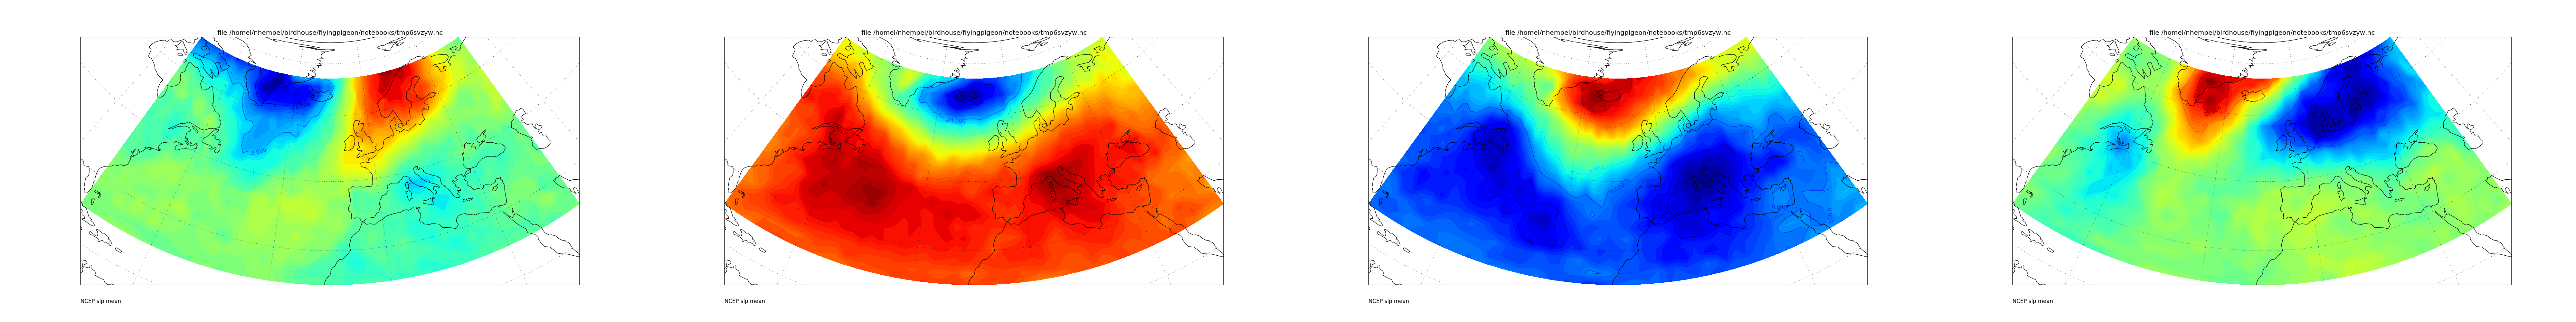

In [9]:
file = nc_obs
pca = wr.get_pca(file)
centroids, distance, regime = wr.calc_kMEAN(pca)

lats, lons = utils.get_coordinates(file)
data = utils.get_values(file)

subplots = []
obs_pattern = []
for i in range(4):
    d_mask = ma.masked_array(distance[:,i], mask=(regime==i))
    best_pattern = d_mask.argsort()[0:10]
    pattern = mean(data[best_pattern], axis = 0)
    obs_pattern.append(pattern)
    subplots.append(plot_pressuremap(pattern, 
    lats=lats, 
    lons=lons, 
    title='file %s' % file , 
    sub_title='NCEP slp mean'))
#    regime_dic['NCEP']['weather regime %s' % i] = mean(data_ncep[best_pattern], axis = 0)

con = concat_images(subplots, orientation='h')
Image(filename=con)

variable name: psl


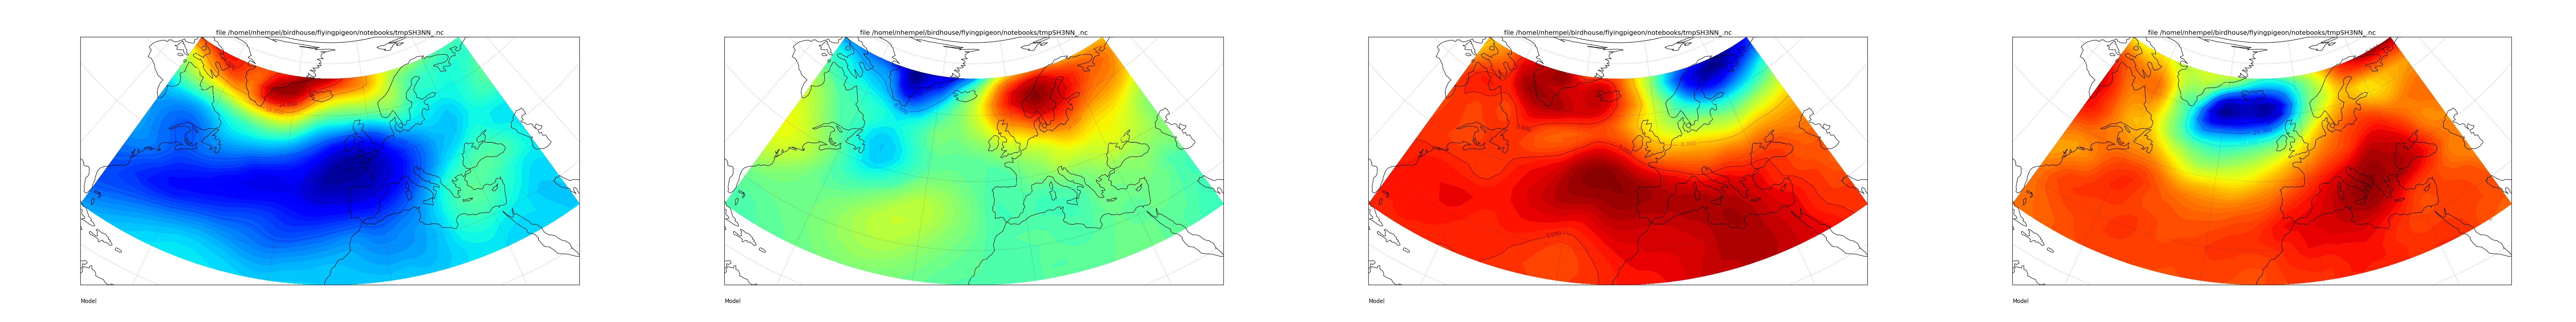

In [10]:
file = nc_model
pca = wr.get_pca(file)
centroids, distance, regime = wr.calc_kMEAN(pca)

lats, lons = utils.get_coordinates(file)
data = utils.get_values(file)
subplots = []
model_pattern = []

for i in range(4):
    d_mask = ma.masked_array(distance[:,i], mask=(regime==i))
    best_pattern = d_mask.argsort()[0:10]
    pattern = mean(data[best_pattern], axis = 0)
    model_pattern.append(pattern)
    subplots.append(plot_pressuremap(pattern,
    lats=lats, 
    lons=lons, 
    title='file %s' % file , 
    sub_title='Model'))

con = concat_images(subplots, orientation='h')
Image(filename=con)

In [20]:
import numpy as np 
from scipy import stats

m, n  = model_pattern[0].shape
for i in [0,1,2,3]:
    print '#######'
    for j in [0,1,2,3]: 
        x = np.reshape(obs_pattern[i], (n*m))
        y = np.reshape(model_pattern[j], (n*m))

        alpha, beta, r_value, p_value, std_err = stats.linregress(x, y)
        print 'OBS Pattern %s to Model Pattern %s: R = %s'  % (i, j , r_value)

#######
OBS Pattern 0 to Model Pattern 0: R = -0.379016281045
OBS Pattern 0 to Model Pattern 1: R = 0.867088942459
OBS Pattern 0 to Model Pattern 2: R = -0.646442246503
OBS Pattern 0 to Model Pattern 3: R = 0.196915837455
#######
OBS Pattern 1 to Model Pattern 0: R = -0.746041440753
OBS Pattern 1 to Model Pattern 1: R = -0.110545942875
OBS Pattern 1 to Model Pattern 2: R = 0.364558712388
OBS Pattern 1 to Model Pattern 3: R = 0.805764074707
#######
OBS Pattern 2 to Model Pattern 0: R = 0.738068345868
OBS Pattern 2 to Model Pattern 1: R = 0.101317703
OBS Pattern 2 to Model Pattern 2: R = -0.409545704466
OBS Pattern 2 to Model Pattern 3: R = -0.781562351362
#######
OBS Pattern 3 to Model Pattern 0: R = 0.351169194263
OBS Pattern 3 to Model Pattern 1: R = -0.843634215704
OBS Pattern 3 to Model Pattern 2: R = 0.707756636115
OBS Pattern 3 to Model Pattern 3: R = -0.250884291492
